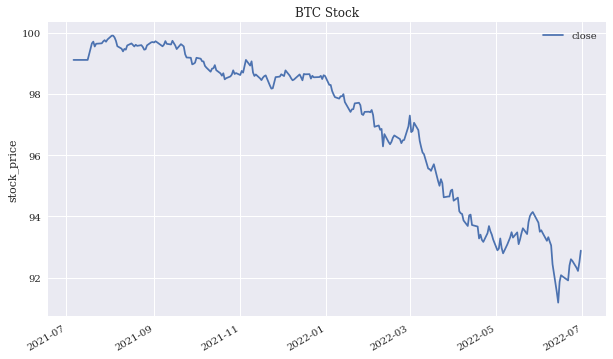

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2021-07-06 to 2022-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


Model framework:
input dim: 1
hidden dim: 36
num layers: 2
output dim: 1

Epoch: 0 MSE: 0.4876302182674408
Epoch: 10 MSE: 0.2826050817966461
Epoch: 20 MSE: 0.19330117106437683
Epoch: 30 MSE: 0.17023755609989166
Epoch: 40 MSE: 0.16753119230270386
Epoch: 50 MSE: 0.1673116385936737
Epoch: 60 MSE: 0.1673203855752945
Epoch: 70 MSE: 0.16733424365520477
Epoch: 80 MSE: 0.16729825735092163
Epoch: 90 MSE: 0.16725973784923553
Epoch: 100 MSE: 0.16725970804691315
Epoch: 110 MSE: 0.16725826263427734
Epoch: 120 MSE: 0.16725726425647736
Epoch: 130 MSE: 0.16725707054138184
Epoch: 140 MSE: 0.16725707054138184




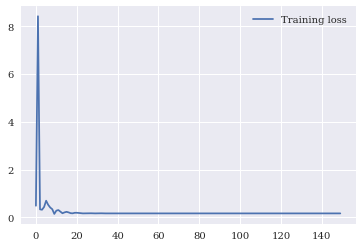

Train Score: 1.78 RMSE
Train Score: 0.89 NRMSE
Test Score: 4.72 RMSE
Test Score: 2.36 NRMSE


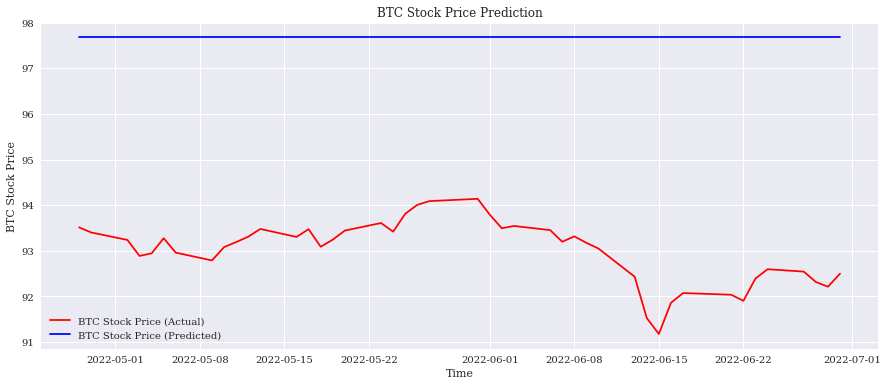

In [84]:
###
### Import Libraries
###

import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

from yahoo_fin.stock_info import get_data
import os

###
### Build functions
###

def get_stock_info(stock_ticker, start_date, end_date):
    df = get_data(stock_ticker, start_date=start_date, end_date=end_date, index_as_date = True, interval="1d")
    df = df.astype({'high':'float','close':'float','volume':'float'})
    return df

def load_data(stock, look_back):
    data_raw = stock.values
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    arr_std = np.std(data)
    arr_rge = np.amax(data) - np.amin(data)

    return [x_train, y_train, x_test, y_test, arr_rge]

###
### Model functions
###

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Get Data
df = get_stock_info(stock_ticker="BTC", start_date="07/06/2021", end_date="07/01/2022")
df.fillna(method='pad')

# Visualize stock timeline
df[['close']].plot(figsize=(10,6))
plt.ylabel("stock_price")
plt.title("BTC Stock")
plt.show()

# Print data info
df = df[['close']]
df.info()
print('\n')

# Set up data
df = df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1,1))
df['close'] = scaler.fit_transform(df['close'].values.reshape(-1,1))

look_back = 28
x_train, y_train, x_test, y_test, arr_rge = load_data(df, look_back = look_back)

# Print data shape
# print(f'x_train.shape = {x_train.shape}')
# print(f'y_train.shape = {y_train.shape}')
# print(f'x_test.shape = {x_test.shape}')
# print(f'y_test.shape = {y_test.shape}')
# print('\n')

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# Print training data size
y_train.size(), x_train.size()

# Model setup
input_dim = 1
hidden_dim = 36
num_layers = 2
output_dim = 1

print(f'Model framework:\ninput dim: {input_dim}\nhidden dim: {hidden_dim}\nnum layers: {num_layers}\noutput dim: {output_dim}\n')

model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers)
loss_fn = torch.nn.MSELoss()

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# print(model)
# print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())
# print('\n')

# Model training
num_epochs = 150
hist = np.zeros(num_epochs)

seq_dim = look_back-1

for epoch in range(num_epochs):

    # Forward step
    y_train_pred = model(x_train)

    # Calculate loss
    loss = loss_fn(y_train_pred, y_train)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} MSE: {loss.item()}')

    hist[epoch] = loss.item()

    # Reset optimizer
    optimizer.zero_grad()

    # Backward step
    loss.backward()

    # Update optimizer
    optimizer.step()

print('\n')

# Display loss over training
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

# Display data shape
# np.shape(y_train_pred)

# Calculate model score
y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Train Score: {trainScore / arr_rge:.2f} NRMSE')
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print(f'Test Score: {testScore:.2f} RMSE')
print(f'Test Score: {testScore / arr_rge:.2f} NRMSE')

# Display model results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color='red', label = 'BTC Stock Price (Actual)')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color='blue', label = 'BTC Stock Price (Predicted)')

plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

In [45]:
torch.save(model.state_dict(), 'BTC_Model_v1_0_1')